## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*

# <center> **Часть II. Разведывательный анализ и моделирование.**

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.stats as sm 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest

from functions import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

## Данные

Читаем данные

In [2]:
data = pd.read_csv('data/data_edited.csv')

data

,status for sale,status coming soon,status new,status foreclosure,status pre-foreclosure,status pending,status auction,status active,status show,status for rent,...,school distance mean,school rating nearest,school distance to best,schools with k,schools with pk,schools with preschool,school grades,target per month,target plus,target
0,0,0,0,0,0,0,0,1,0,0,...,5.537500,7,5.10,3,2,0,13,0,0,418.000
1,1,0,0,0,0,0,0,0,0,0,...,1.326667,4,1.65,1,1,0,13,0,0,310.000
2,1,0,0,0,0,0,0,0,0,0,...,1.960000,8,1.19,1,0,0,13,0,0,2895.000
3,1,0,0,0,0,0,0,0,0,0,...,0.752500,9,1.05,1,1,0,13,0,0,2395.000
4,1,0,0,0,0,0,0,0,0,0,...,4.080000,4,3.25,1,1,0,13,0,0,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360187,1,0,0,0,0,0,0,0,0,0,...,0.250000,3,0.40,1,1,0,13,0,0,799.000
360188,0,0,0,0,0,0,0,0,0,0,...,16.600000,10,32.10,1,1,0,13,0,0,1249.000
360189,1,0,0,0,0,0,0,0,0,0,...,4.143333,1,0.40,1,1,0,13,0,0,674.999
360190,1,0,0,0,0,0,0,0,0,0,...,0.605000,4,0.48,1,1,0,9,0,0,528.000


In [3]:
get_data_info(data)

,Nulls,Uniques,Dtypes
status for sale,0.0,2,int64
status coming soon,0.0,2,int64
status new,0.0,2,int64
status foreclosure,0.0,2,int64
status pre-foreclosure,0.0,2,int64
...,...,...,...
schools with preschool,0.0,11,int64
school grades,0.0,13,int64
target per month,0.0,2,int64
target plus,0.0,2,int64


## Разведывательный анализ

### Бинарные переменные

In [4]:
bin_cols = set()
num_cols = []

for col in data.columns:
    if ('target' not in col) and (data[col].nunique() == 2):
        bin_cols.add(col.split()[0])
    else:
        num_cols.append(col)

bin_cols, num_cols

({'cooling', 'heating', 'parking', 'propertyType', 'status'},
 ['baths',
  'beds',
  'sqft area',
  'property age',
  'property remodeled',
  'p. spaces',
  'lotsize',
  'zipcode 0',
  'zipcode 1',
  'zipcode 2',
  'zipcode 3',
  'zipcode 4',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school rating nearest',
  'school distance to best',
  'schools with k',
  'schools with pk',
  'schools with preschool',
  'school grades',
  'target per month',
  'target plus',
  'target'])

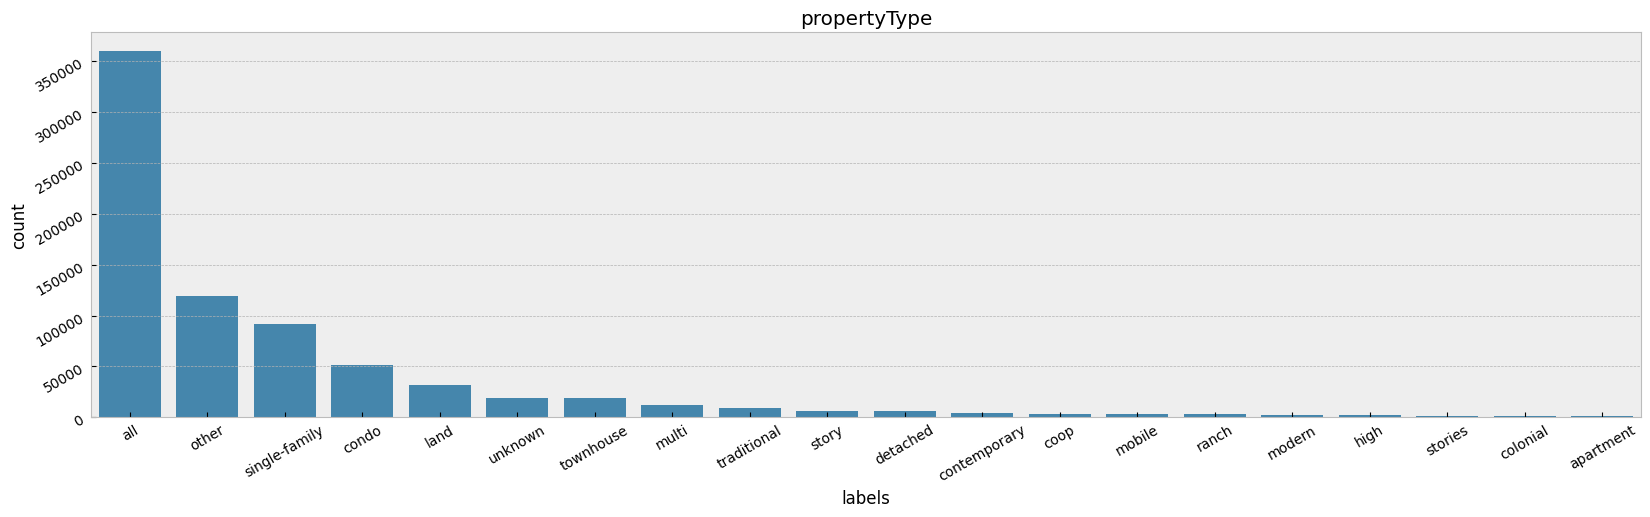

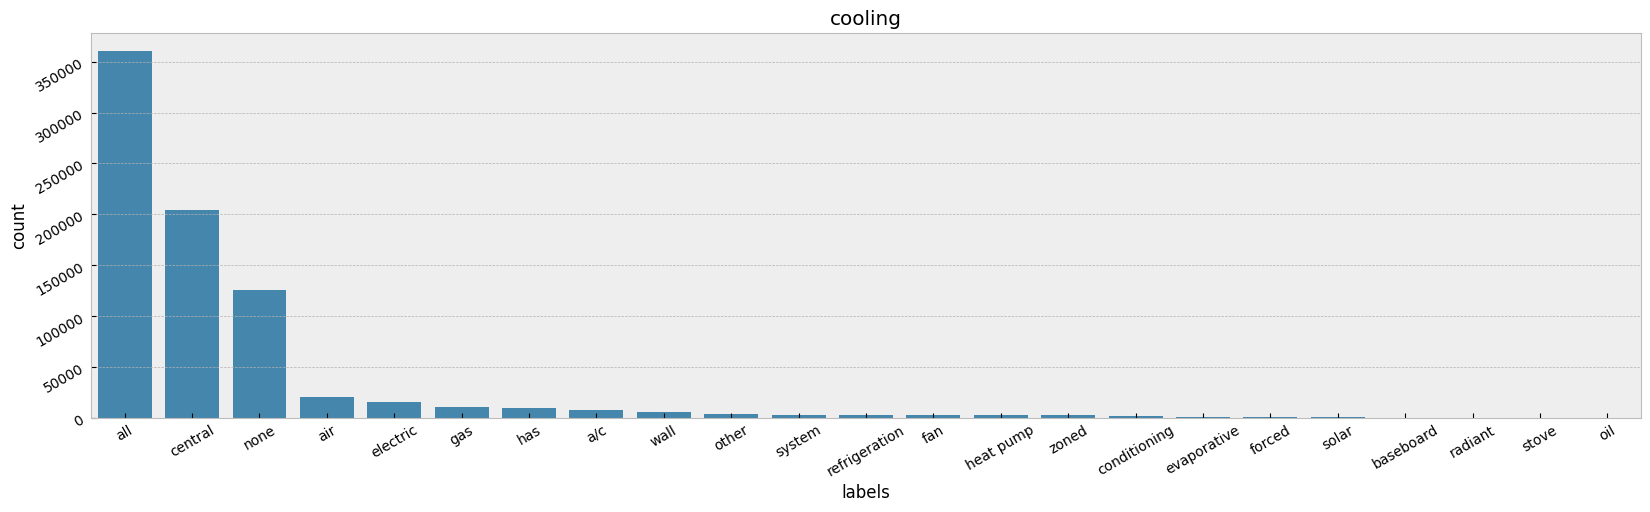

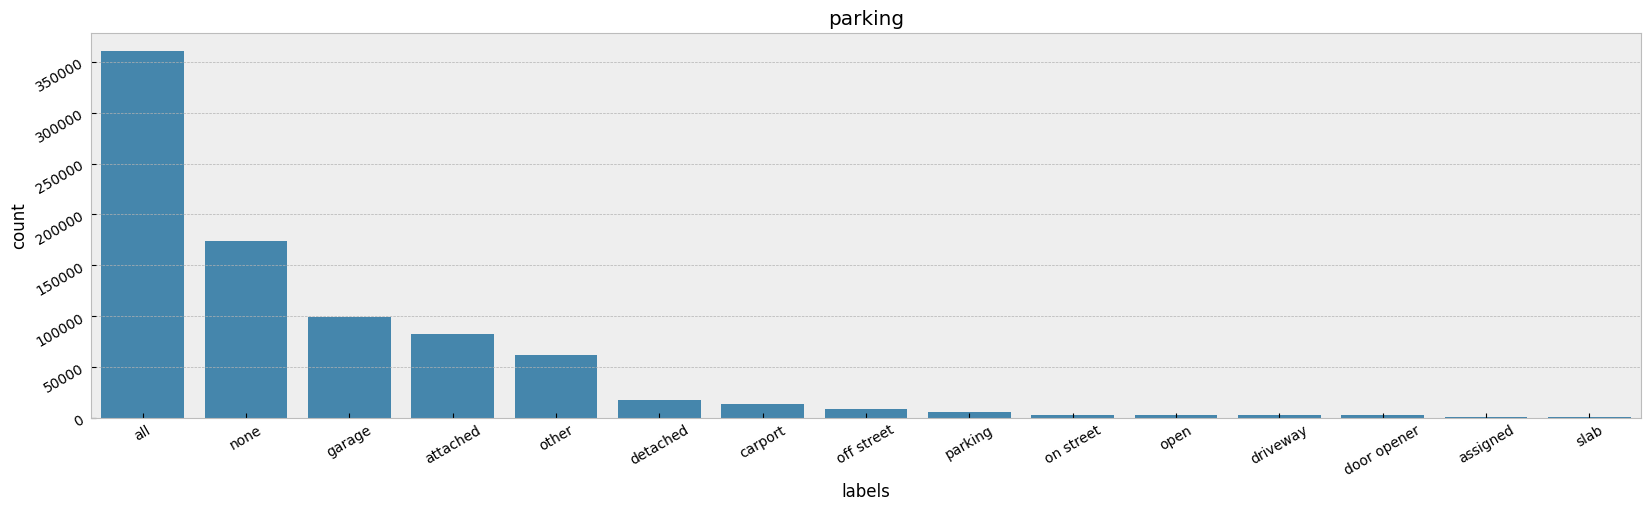

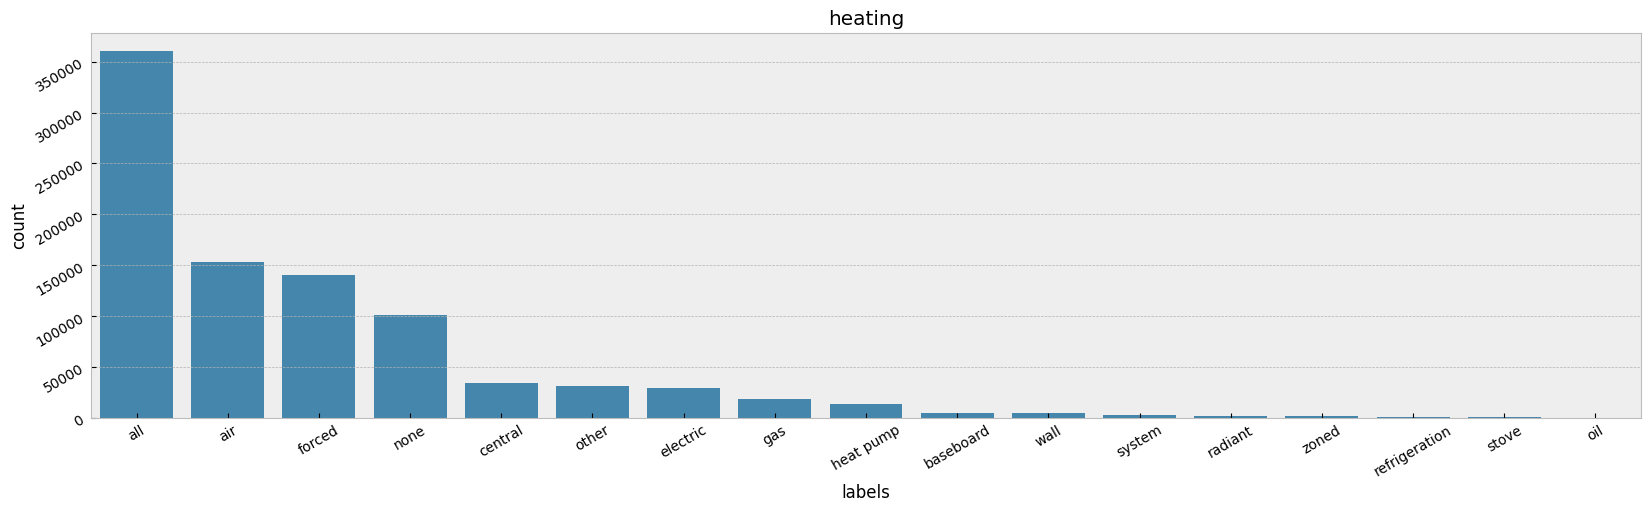

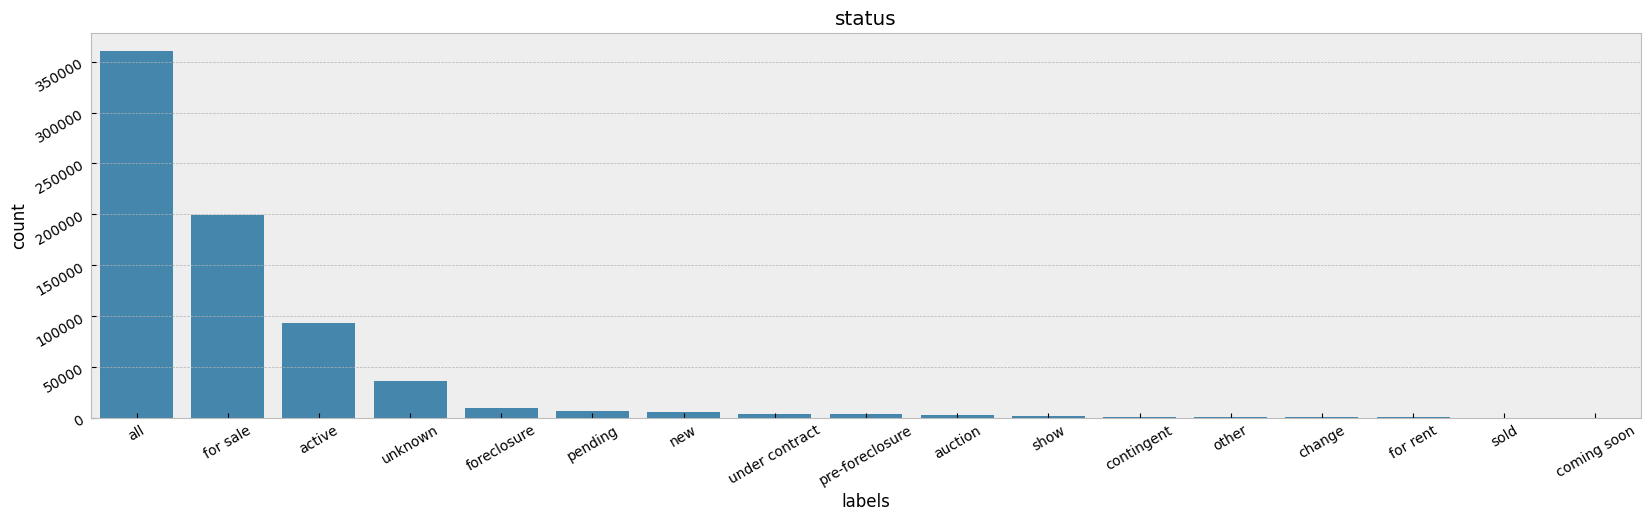

In [5]:
def show_barplot(cols, data=data, figsize=(20, 5)):
    sums = get_sums(data, cols).sort_values(ascending=False)

    col_list = sums.index.tolist() + ['all']
    vls_list = sums.values.tolist() + [data.shape[0]]

    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(cols+' ', '')

    df = (pd.DataFrame({'labels': col_list, 
                        'count': vls_list})
          .sort_values('count', ascending=False))
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(df, x='labels', y='count', ax=ax)
    ax.tick_params(rotation=30)
    ax.set_title(cols)
    
    return fig 


for col in bin_cols:
    show_barplot(col).show()

### Количественные переменные

In [6]:
def test_normality(labels, 
                   data=data, 
                   testfunc='shapiro', 
                   alpha=0.05):
    
    norm_df = pd.DataFrame(index=labels)
    
    pv_list = []
    for col in data[labels].columns:
        x = data[col]
        
        if testfunc == 'dagostino':
            p = ss.normaltest(x)
            pv = round(p.pvalue[0], 3)
            alpha = alpha / 2

        p = ss.shapiro(x)
        pv = round(p.pvalue, 3)
        
        pv_list.append(pv)
    
    norm_df['p_value'] = pv_list
    norm_df['is_normal'] = norm_df['p_value'].apply(lambda x: 0 if x > alpha else 1)

    return norm_df

In [7]:
test_normality(num_cols)

,p_value,is_normal
baths,0.0,1
beds,0.0,1
sqft area,0.0,1
property age,0.0,1
property remodeled,0.0,1
p. spaces,0.0,1
lotsize,1.0,0
zipcode 0,0.0,1
zipcode 1,0.0,1
zipcode 2,0.0,1


In [44]:
def show_boxhistplot(col, data=data, figsize=(10, 5)):    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    
    sns.boxplot(data, 
                x=col, 
                fill=False, 
                ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('box')
    ax[0].set_title(col)
    
    sns.histplot(data, 
                 x=col, 
                 bins=data[col].nunique(), 
                 ax=ax[1])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('hist')
    
    sns.kdeplot(data, 
                x=col, 
                ax=ax[2])
    ax[2].set_xlabel('')
    ax[2].set_ylabel('kde')
    
    return fig

In [182]:
def fix_data(feature, data=data, figsize=(20, 7)):
    fig, ax = plt.subplots(3, 2, figsize=figsize)
    
    
    x = data[feature]
    
    sns.boxplot(x=x, fill=False, ax=ax[0, 0])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('box')
    ax[0, 0].set_title(feature+' original')

    sns.histplot(x=x, bins=x.nunique(), ax=ax[1, 0])
    ax[1, 0].set_xlabel('')
    ax[1, 0].set_ylabel('hist')
    
    sns.kdeplot(x=x, ax=ax[2, 0])
    ax[2, 0].set_xlabel('')
    ax[2, 0].set_ylabel('kde')


    lim = x.quantile(0.99)
    fixed = data[x <= lim][x >= -lim].reset_index(drop=True)
    
    xnew = fixed[feature]
    
    sns.boxplot(x=xnew, fill=False, ax=ax[0, 1])
    ax[0, 1].set_xlabel('')
    ax[0, 1].set_ylabel('box')
    ax[0, 1].set_title(feature+' fixed')
    
    sns.histplot(x=xnew, bins=xnew.nunique(), ax=ax[1, 1])
    ax[1, 1].set_xlabel('')
    ax[1, 1].set_ylabel('hist')
    
    sns.kdeplot(x=xnew, ax=ax[2, 1])
    ax[2, 1].set_xlabel('')
    ax[2, 1].set_ylabel('kde')
    
    fig.show()
    print(f'{fixed.shape[0]} rows X {fixed.shape[1]} cols')
    
    return fixed

357192 rows X 112 cols


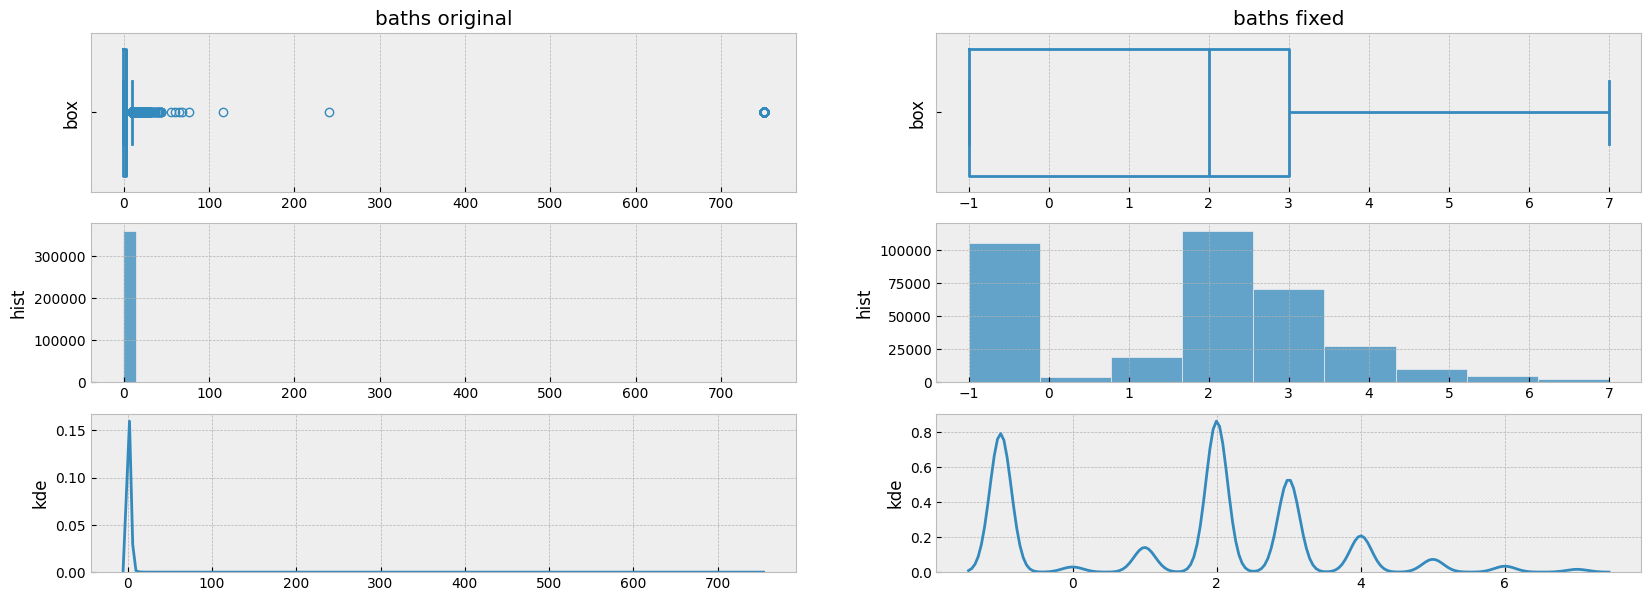

In [183]:
X = fix_data('baths')

353996 rows X 112 cols


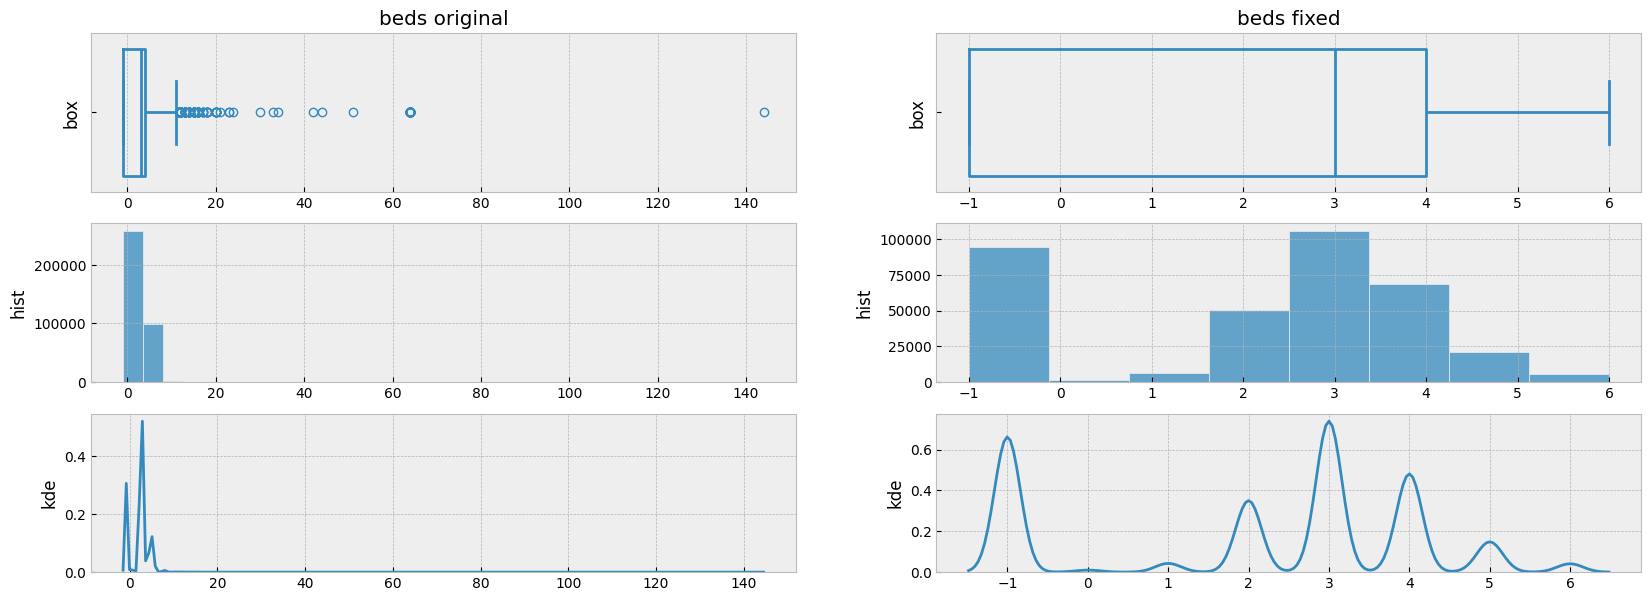

In [184]:
X = fix_data('beds', data=X)

350456 rows X 112 cols


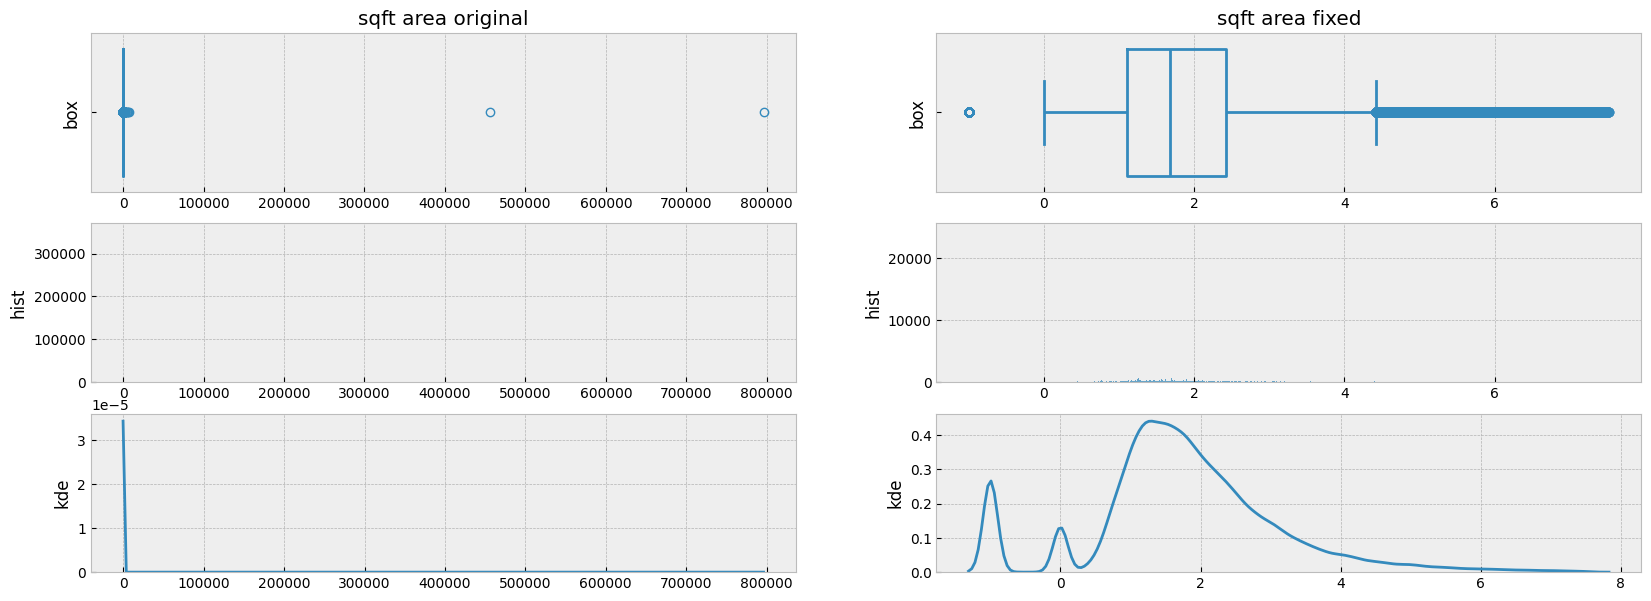

In [185]:
X = fix_data('sqft area', data=X) 

347098 rows X 112 cols


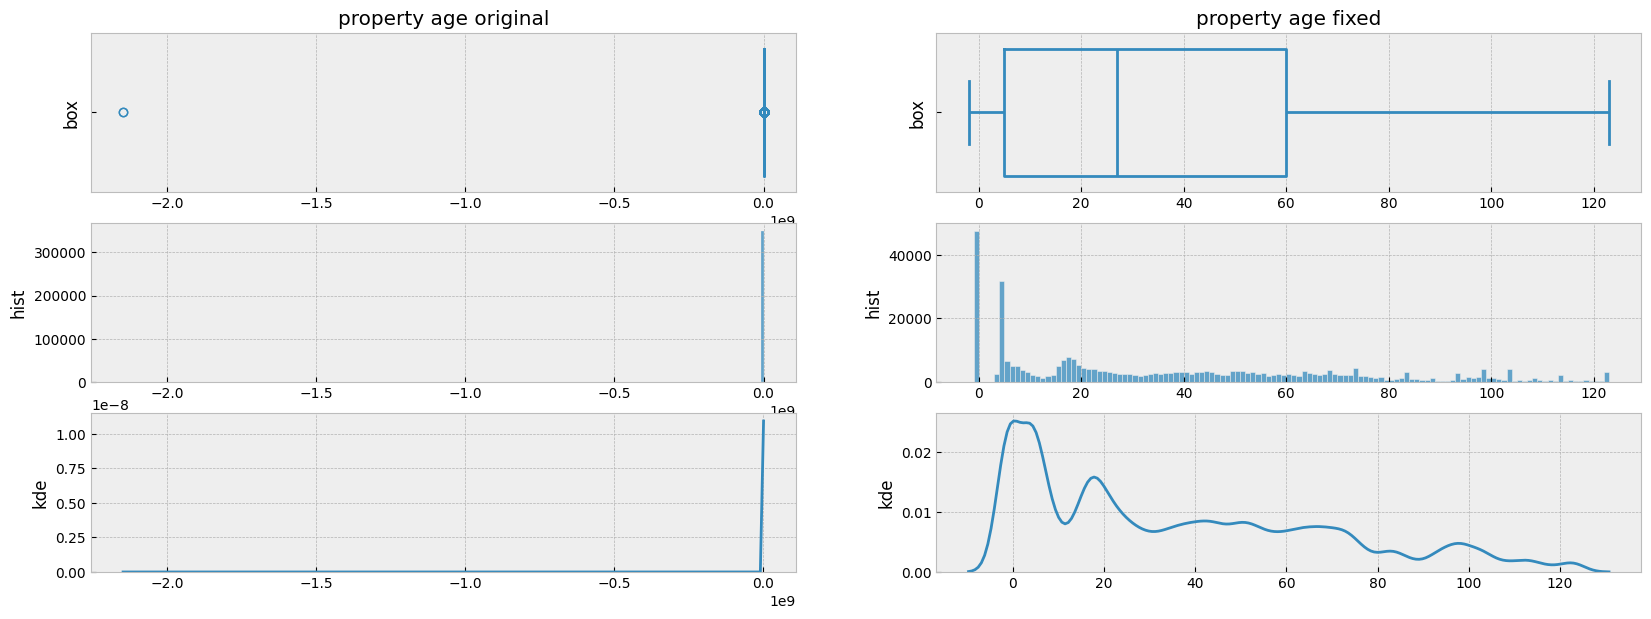

In [186]:
X = fix_data('property age', data=X)

343702 rows X 112 cols


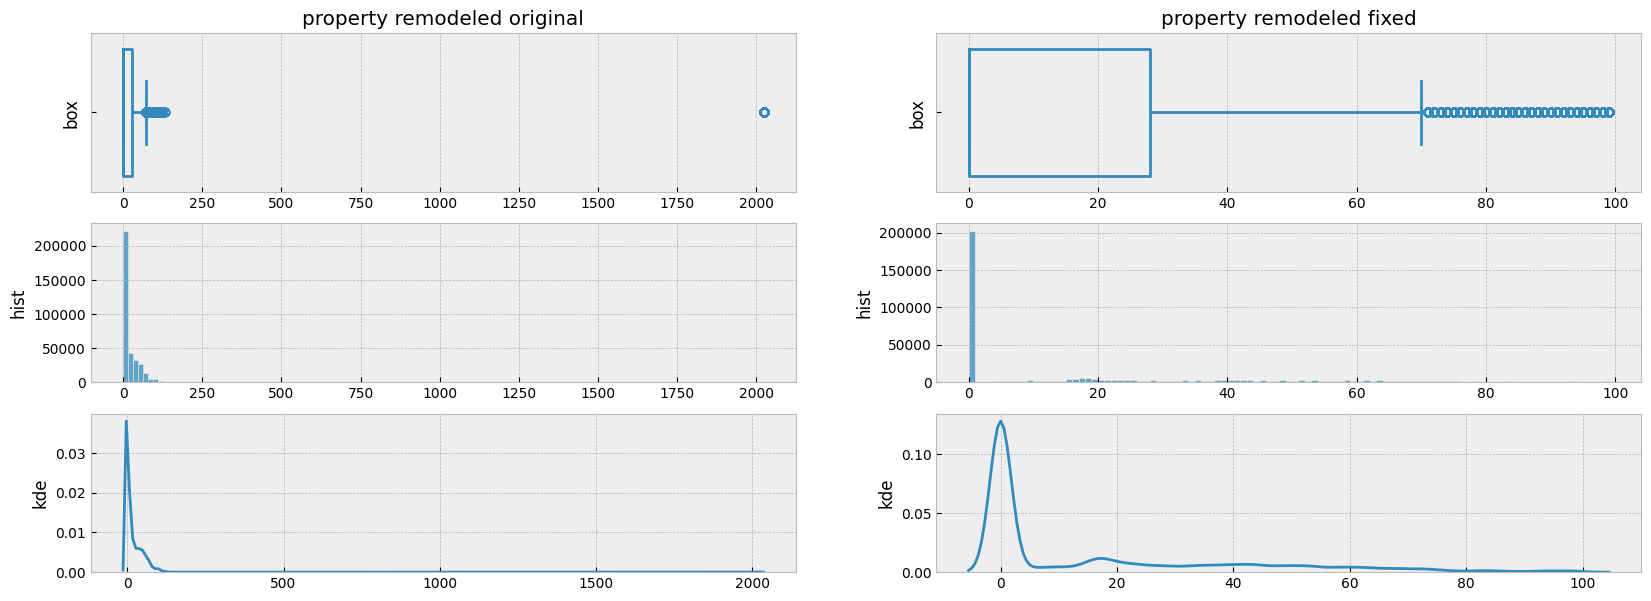

In [188]:
X = fix_data('property remodeled', data=X) 

341530 rows X 112 cols


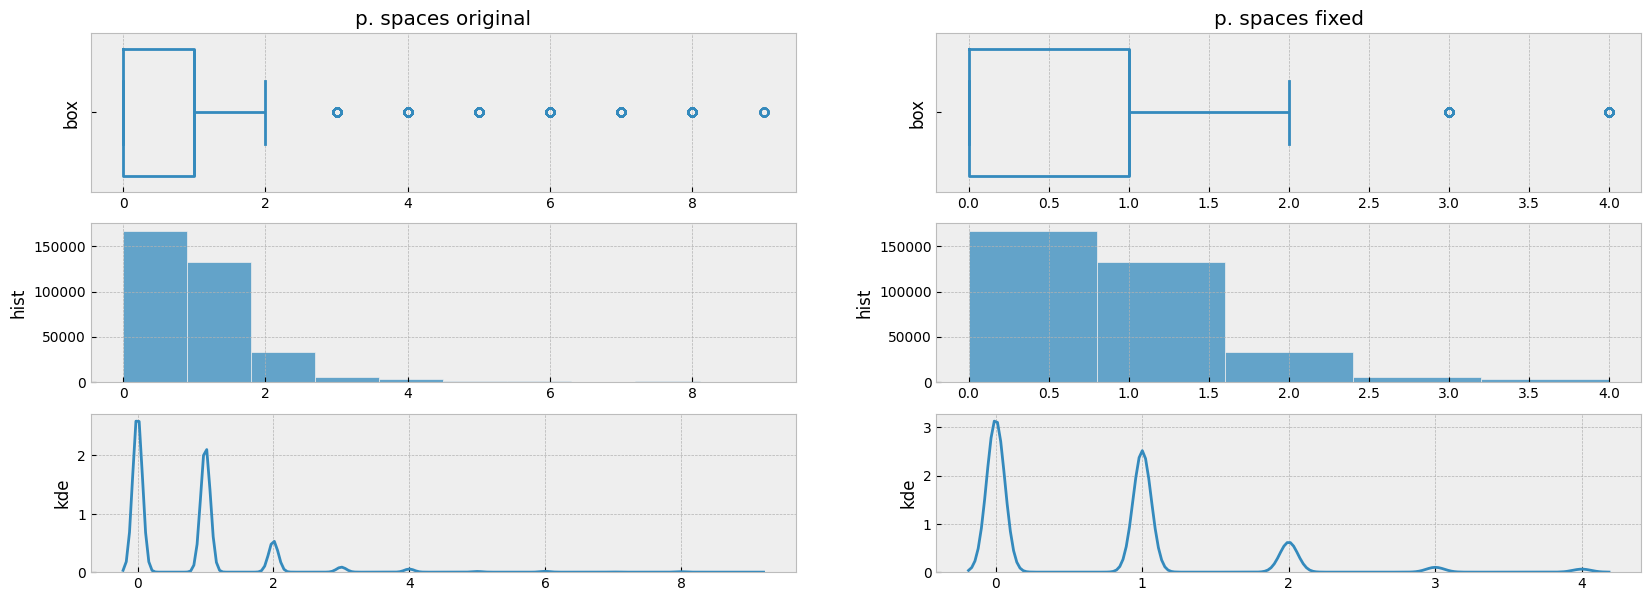

In [189]:
X = fix_data('p. spaces', data=X)

336917 rows X 112 cols


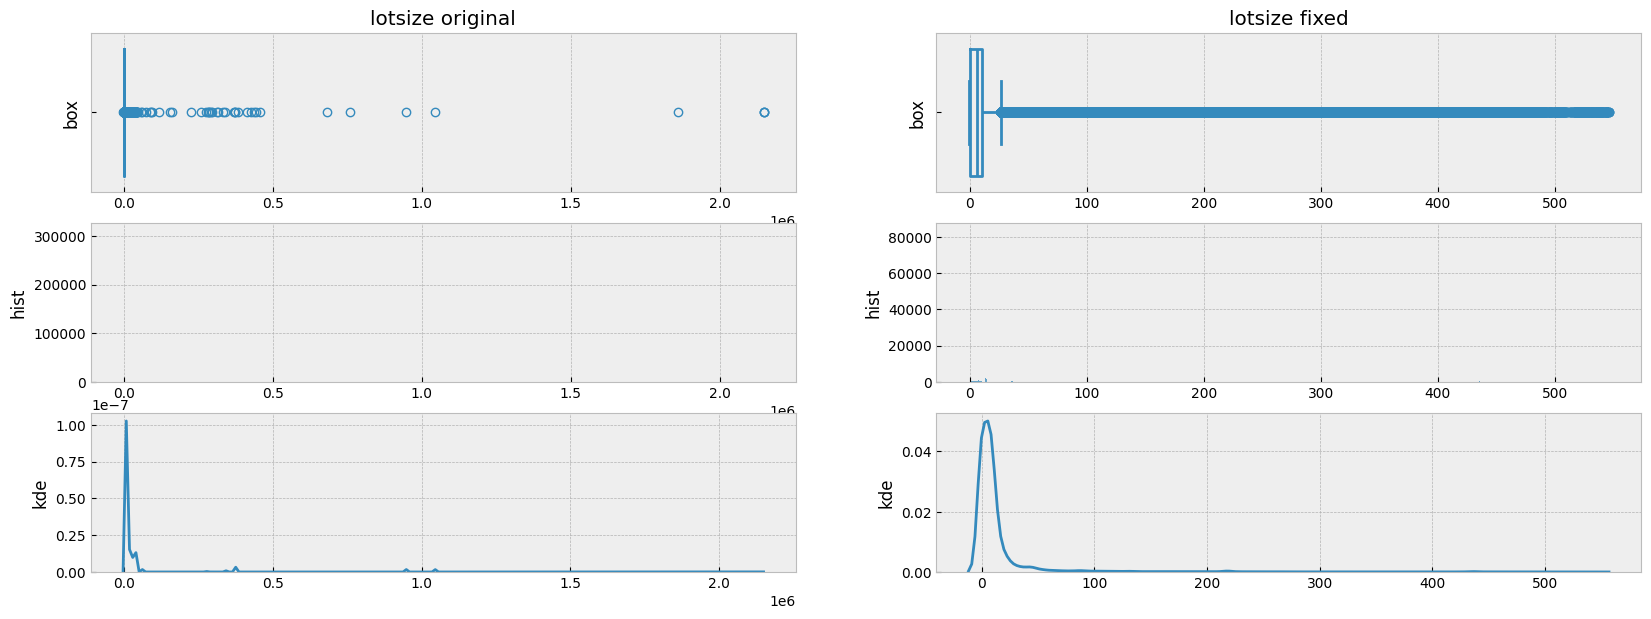

In [190]:
X = fix_data('lotsize', data=X)

In [191]:
num_cols

['baths',
 'beds',
 'sqft area',
 'property age',
 'property remodeled',
 'p. spaces',
 'lotsize',
 'zipcode 0',
 'zipcode 1',
 'zipcode 2',
 'zipcode 3',
 'zipcode 4',
 'school rating sum',
 'school rating mean',
 'school distance nearest',
 'school distance mean',
 'school rating nearest',
 'school distance to best',
 'schools with k',
 'schools with pk',
 'schools with preschool',
 'school grades',
 'target per month',
 'target plus',
 'target']